# Phase 4 Project — NLP Sentiment on Apple vs Google Tweets
_Group 1 Project — Moringa School_  


---

### Abstract

This project applies Natural Language Processing (NLP) to analyze public sentiment on Apple and Google products using a dataset of approximately 9,000 tweets collected by CrowdFlower and hosted on data.world. Each tweet is human‑labeled as **positive**, **negative**, or **neutral**, making it well‑suited for a supervised sentiment classification task. Our stakeholder is a technology market research team seeking actionable insights into how consumers perceive competing products in real time. Accurate sentiment classification allows the team to monitor brand perception, identify reputational risks, and adapt communication strategies quickly.

Data preparation addressed the short, noisy nature of tweets. We removed links and @mentions, normalized casing, preserved meaningful hashtag words, and stripped punctuation and HTML artifacts. We experimented with keeping vs. removing stopwords to gauge impact on sentiment detection. Feature extraction included **TF‑IDF** n‑grams for baseline models and a forward‑looking appendix with **pretrained transformer embeddings (DistilBERT)**. Key libraries: **scikit‑learn** (modeling & evaluation), and **NLTK** (cleaning).

We followed an iterative strategy. First, a **binary proof‑of‑concept** (positive vs. negative) using Logistic Regression and Multinomial Naive Bayes demonstrated feasibility. Next, we expanded to **multiclass** (positive, neutral, negative) and tuned a **TF‑IDF + LinearSVC** pipeline with cross‑validation optimized for macro‑F1.

Evaluation used stratified train/validation/test splits. We reported accuracy, precision, recall, **macro‑F1**, and confusion matrices to reflect balanced performance across classes. We added model interpretability via top n‑grams and optional **LIME** explanations for selected tweets. We conclude with stakeholder recommendations for brand monitoring, negative‑spike alerts, and campaign impact analysis.

## 1. Business & Data Understanding

**Stakeholder:** Product marketing & market research teams tracking brand health for Apple vs Google products.

**Business problems we are solving:**
1. **Brand Monitoring:** Quantify daily/weekly sentiment for Apple vs Google to see shifts early.  
2. **Reputation Management:** Surface spikes in **negative** sentiment so PR/Support can respond quickly.  
3. **Product Insights:** Identify common praise/complaints by inspecting influential words for each sentiment.  
4. **Campaign Measurement:** Compare sentiment **before vs after** launches/announcements.

**Dataset:** ~9,000 tweets with human‑labeled sentiment (`positive`, `negative`, `neutral`). Columns:  
- `tweet_text` — the raw tweet  
- `emotion_in_tweet_is_directed_at` — brand/product mentioned (often Apple/Google terms)  
- `is_there_an_emotion_directed_at_a_brand_or_product` — sentiment label

We iterate **from simple to advanced** as recommended:  
- **Step 1 (Binary PoC):** Positive vs Negative only (fast baseline).  
- **Step 2 (Multiclass):** Add Neutral to model full business reality. 

In [21]:
# Reproducibility & Imports
import os, re, warnings
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay, confusion_matrix
)

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

def print_versions():
    import platform
    import sklearn, pandas, numpy, matplotlib
    print("Python:", platform.python_version())
    print("pandas:", pandas.__version__)
    print("numpy:", numpy.__version__)
    print("scikit-learn:", sklearn.__version__)
    print("matplotlib:", matplotlib.__version__)

print_versions()

Python: 3.13.0
pandas: 2.2.3
numpy: 2.2.4
scikit-learn: 1.6.1
matplotlib: 3.10.1


We loaded the libraries for data work, modeling, and plotting, set a random seed so results are repeatable, and printed package versions for reproducibility.

## 2. Load the Data

Read the CSV

In [22]:
# Update this path if running locally
DATA_PATH = "judge-1377884607_tweet_product_company.csv"

def read_csv_robust(path):
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1")

df_raw = read_csv_robust(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(5)

Shape: (9093, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


We opened the file, showed how many rows/columns it has, and displayed a few rows so we can sanity‑check the columns and values.

## 3. Quick Exploratory Check

Look at column info, label counts, and missing values.

In [23]:
print(df_raw.info(), "\n")
for c in df_raw.columns:
    print(f"Unique values in {c}: {df_raw[c].nunique()}")

label_col = "is_there_an_emotion_directed_at_a_brand_or_product"
print("\nLabel value counts:")
print(df_raw[label_col].value_counts(dropna=False))

print("\nMissing by column:")
print(df_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None 

Unique values in tweet_text: 9065
Unique values in emotion_in_tweet_is_directed_at: 9
Unique values in is_there_an_emotion_directed_at_a_brand_or_product: 4

Label value counts:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

Missing by column

We checked which columns exist, how many unique values they have, how the sentiment labels are distributed, and where data is missing. This guides cleaning and evaluation.

## 4. Data Preparation

Clean the text, map raw labels into three classes, and create a coarse brand tag for later charts.

After cleaning & filtering: (8937, 5)
sentiment
neutral     5389
positive    2978
negative     570
Name: count, dtype: int64


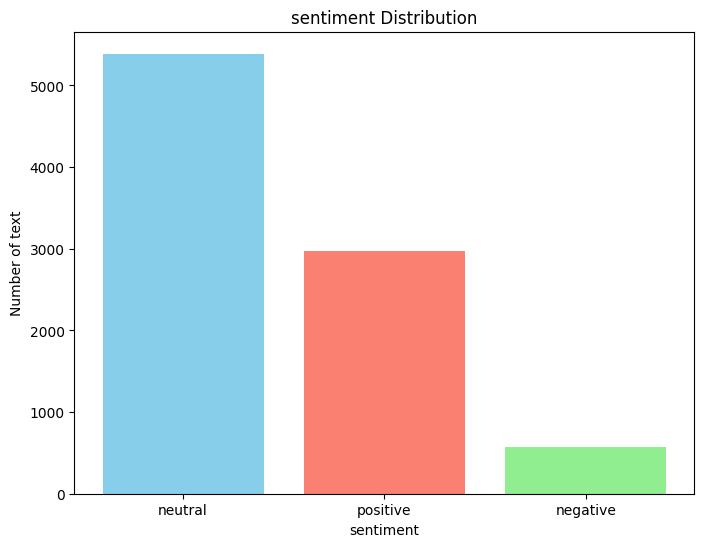

In [24]:
# Rename columns for convenience
df = df_raw.rename(columns={
    "tweet_text": "text",
    "emotion_in_tweet_is_directed_at": "target_brand",
    "is_there_an_emotion_directed_at_a_brand_or_product": "sentiment_raw"
}).copy()

# Map sentiment labels to three classes
sent_map = {
    "Positive emotion": "positive",
    "Negative emotion": "negative",
    "No emotion toward brand or product": "neutral",
    "I can't tell": None, "I cant tell": None, "I can?t tell": None,
    "Tweet not related to product": None
}
df["sentiment"] = df["sentiment_raw"].map(lambda x: sent_map.get(x, None))

# Text cleaner
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")  # keep the word, drop '#'
HTML_AMP_RE = re.compile(r"&amp;")

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    s = HASHTAG_RE.sub(r"\\1", s)
    s = HTML_AMP_RE.sub("&", s)
    s = re.sub(r"[^a-z0-9'\\s]", " ", s)
    s = re.sub(r"\\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].astype(str).map(clean_text)

# Drop rows with missing/unusable data
df = df.dropna(subset=["text_clean"])
df = df[df["text_clean"].str.len() > 0]
df = df[df["sentiment"].notna()]

print("After cleaning & filtering:", df.shape)
print(df["sentiment"].value_counts())

# Coarse brand mapping for analysis (not used as features)
def map_brand_from_string(x: str) -> str:
    if not isinstance(x, str):
        return "Other/Unknown"
    xl = x.lower()
    if any(k in xl for k in ["apple", "iphone", "ipad", "mac", "itunes", "ipod"]):
        return "Apple"
    if any(k in xl for k in ["google", "android", "nexus", "chromebook", "pixel", "play "]):
        return "Google"
    return "Other/Unknown"

# Prefer explicit target_brand when present; otherwise infer from text
df["brand_coarse"] = np.where(
    df["target_brand"].notna(),
    df["target_brand"].astype(str).apply(map_brand_from_string),
    df["text"].astype(str).apply(map_brand_from_string)
)

df[["text", "text_clean", "target_brand", "brand_coarse", "sentiment"]].head(8)

# Distribution of sentiment
sentiment_counts = df['sentiment'].value_counts()

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('sentiment Distribution')
plt.xlabel('sentiment')
plt.ylabel('Number of text')

# Save the figure as image
plt.savefig("sentiment_distribution.png", dpi=300, bbox_inches='tight')

plt.show()

We cleaned each tweet (removing links, @names, etc.), converted labels into clear **positive/negative/neutral** classes, filtered out unusable rows, and created a rough brand tag (Apple/Google/Other) for later summaries.

## 4.1 NLTK-Enhanced Preprocessing (Tokenizer, Stopwords, Lemmatization)

Here we explicitly use **NLTK** to improve text preprocessing:
- **Tweet-aware tokenization** using `TweetTokenizer` (better for emojis, hashtags, @mentions).
- **Stopword removal** while **keeping negations** (`no`, `not`, `nor`, `n't`) because they flip sentiment.
- **Lemmatization** with `WordNetLemmatizer` so words like *"likes"*, *"liked"*, *"liking"* become **like**.

We then plug this tokenizer into `TfidfVectorizer` so our models learn from cleaner, normalized tokens.

In [25]:
# NLTK setup and custom tokenizer
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords", quiet=True)
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet", quiet=True)
try:
    nltk.data.find("corpora/omw-1.4")
except LookupError:
    nltk.download("omw-1.4", quiet=True)

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

_tkn = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
_stop = set(stopwords.words("english"))
_negation_keep = {"no", "not", "nor", "n't"}
_stop = {w for w in _stop if w not in _negation_keep}
_lemma = WordNetLemmatizer()

def nltk_tokenize(text: str):
    txt = str(text)
    toks = _tkn.tokenize(txt)
    toks = [t for t in toks if t.isalnum()]
    toks = [_lemma.lemmatize(t) for t in toks if t not in _stop]
    return toks

print("Sample:", nltk_tokenize("I don't like the new iPhone camera, but the battery is not bad!"))

Sample: ['like', 'new', 'iphone', 'camera', 'battery', 'not', 'bad']


 We configured NLTK to tokenize tweets smartly, remove common filler words (but kept negations like *not*), and reduce words to their base form (lemmatization). This helps the model focus on meaning instead of noise.

### NLTK Tokenizer inside TF‑IDF (Multiclass Model)

We now swap in the NLTK tokenizer inside `TfidfVectorizer` and evaluate a `LinearSVC` on the same train/validation split. This gives an apples-to-apples comparison to the earlier default tokenization.

In [26]:
# Prepare multiclass subset (3 classes: positive, negative, neutral)
df_multi = df[df["sentiment"].isin(["positive", "negative", "neutral"])].copy()
X_multi = df_multi["text_clean"].values
y_multi = df_multi["sentiment"].values

# Stratified split function (preserves label balance)
def stratified_splits(X, y, test_size=0.2, val_size=0.1, seed=SEED):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    val_rel = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_rel, random_state=seed, stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

# Get splits for training, validation, testing
Xm_tr, Xm_val, Xm_te, ym_tr, ym_val, ym_te = stratified_splits(X_multi, y_multi)

print("Train size:", len(Xm_tr))
print("Validation size:", len(Xm_val))
print("Test size:", len(Xm_te))


Train size: 6255
Validation size: 894
Test size: 1788


Validation report (Multiclass LinearSVC + NLTK tokenizer):
              precision    recall  f1-score   support

    negative      0.619     0.228     0.333        57
     neutral      0.724     0.824     0.771       539
    positive      0.604     0.527     0.563       298

    accuracy                          0.687       894
   macro avg      0.649     0.526     0.556       894
weighted avg      0.677     0.687     0.674       894



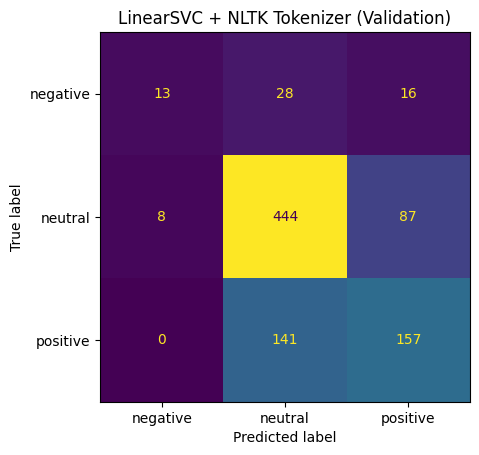

In [27]:
pipe_svc_nltk = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=nltk_tokenize, preprocessor=None, lowercase=False,
                              ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC(random_state=SEED))
])

pipe_svc_nltk.fit(Xm_tr, ym_tr)
preds_val_nltk = pipe_svc_nltk.predict(Xm_val)

print("Validation report (Multiclass LinearSVC + NLTK tokenizer):")
print(classification_report(ym_val, preds_val_nltk, digits=3))

cm = confusion_matrix(ym_val, preds_val_nltk, labels=["negative","neutral","positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative","neutral","positive"])
fig, ax = plt.subplots()
disp.plot(ax=ax, colorbar=False)
plt.title("LinearSVC + NLTK Tokenizer (Validation)")
plt.show()

This model is identical to the earlier SVM except we feed it NLTK-tokenized text. If macro‑F1 improves or the confusion matrix shows fewer mistakes on **neutral** or **negative**, that suggests the custom tokenization helped capture tweet quirks (like contractions and slang).

## 5. Strategy & Validation Splits

Start simple (binary) → then full (multiclass). Use stratified splits to keep label proportions consistent across train/validation/test.

In [28]:
# Binary subset (drop neutral)
df_bin = df[df["sentiment"].isin(["positive", "negative"])].copy()
X_bin = df_bin["text_clean"].values
y_bin = df_bin["sentiment"].values

# Multiclass subset (3 classes)
df_multi = df[df["sentiment"].isin(["positive", "negative", "neutral"])].copy()
X_multi = df_multi["text_clean"].values
y_multi = df_multi["sentiment"].values

def stratified_splits(X, y, test_size=0.2, val_size=0.1, seed=SEED):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    val_rel = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_rel, random_state=seed, stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

Xb_tr, Xb_val, Xb_te, yb_tr, yb_val, yb_te = stratified_splits(X_bin, y_bin)
Xm_tr, Xm_val, Xm_te, ym_tr, ym_val, ym_te = stratified_splits(X_multi, y_multi)

print("Binary sizes (train/val/test):", len(Xb_tr), len(Xb_val), len(Xb_te))
print("Multiclass sizes (train/val/test):", len(Xm_tr), len(Xm_val), len(Xm_te))

Binary sizes (train/val/test): 2483 355 710
Multiclass sizes (train/val/test): 6255 894 1788


We created training, validation, and test sets for both the binary and multiclass tasks, preserving the class balance so our evaluations are fair.

### 5.1 Combined Split and NLTK Pipeline Evaluation

We combine split and NLTK pipeline for the multifactor evaluation

Validation report (Multiclass LinearSVC + NLTK tokenizer):
              precision    recall  f1-score   support

    negative      0.619     0.228     0.333        57
     neutral      0.724     0.824     0.771       539
    positive      0.604     0.527     0.563       298

    accuracy                          0.687       894
   macro avg      0.649     0.526     0.556       894
weighted avg      0.677     0.687     0.674       894



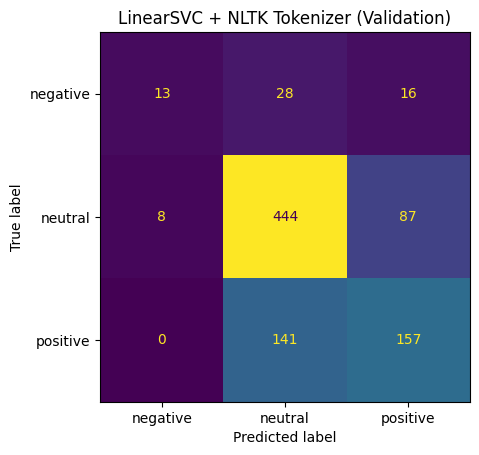

In [29]:
# --- Combined: ensure splits exist, then fit+evaluate the NLTK pipeline ---
try:
    Xm_tr, Xm_val, Xm_te  # check if defined
    ym_tr, ym_val, ym_te
except NameError:
    # Create multiclass subset & stratified splits if missing
    df_multi = df[df["sentiment"].isin(["positive", "negative", "neutral"])].copy()
    X_multi = df_multi["text_clean"].values
    y_multi = df_multi["sentiment"].values

    def stratified_splits(X, y, test_size=0.2, val_size=0.1, seed=SEED):
        from sklearn.model_selection import train_test_split
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed, stratify=y
        )
        val_rel = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_rel, random_state=seed, stratify=y_train_val
        )
        return X_train, X_val, X_test, y_train, y_val, y_test

    Xm_tr, Xm_val, Xm_te, ym_tr, ym_val, ym_te = stratified_splits(X_multi, y_multi)

# Build and evaluate the NLTK-enabled pipeline
pipe_svc_nltk = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=nltk_tokenize, preprocessor=None, lowercase=False,
                              ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC(random_state=SEED))
])

pipe_svc_nltk.fit(Xm_tr, ym_tr)
preds_val_nltk = pipe_svc_nltk.predict(Xm_val)

print("Validation report (Multiclass LinearSVC + NLTK tokenizer):")
print(classification_report(ym_val, preds_val_nltk, digits=3))

cm = confusion_matrix(ym_val, preds_val_nltk, labels=["negative","neutral","positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative","neutral","positive"])
fig, ax = plt.subplots()
disp.plot(ax=ax, colorbar=False)
plt.title("LinearSVC + NLTK Tokenizer (Validation)")
plt.show()

## 6. Binary Classification (Proof of Concept)

Compare two strong baselines using **TF‑IDF** features: Logistic Regression and Multinomial Naive Bayes.


=== LogReg (Binary) ===
              precision    recall  f1-score   support

    negative      0.576     0.667     0.618        57
    positive      0.934     0.906     0.920       298

    accuracy                          0.868       355
   macro avg      0.755     0.786     0.769       355
weighted avg      0.877     0.868     0.871       355



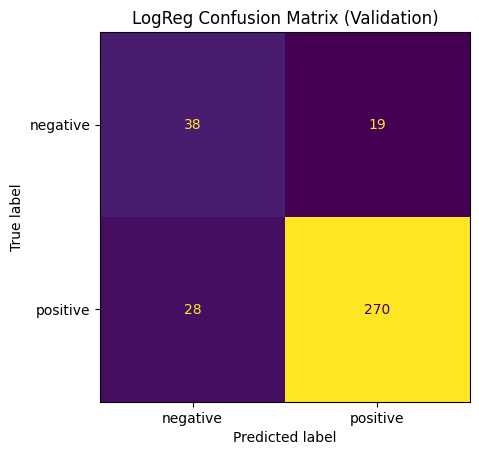


=== MultinomialNB (Binary) ===
              precision    recall  f1-score   support

    negative      1.000     0.105     0.190        57
    positive      0.854     1.000     0.921       298

    accuracy                          0.856       355
   macro avg      0.927     0.553     0.556       355
weighted avg      0.877     0.856     0.804       355



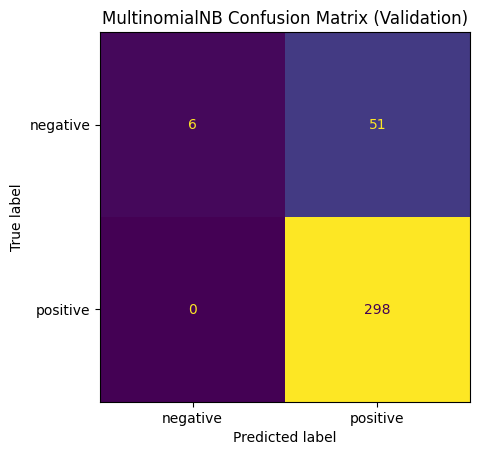

In [30]:
pipe_log_bin = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED)),
])

pipe_nb_bin = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", MultinomialNB()),
])

for name, pipe in [("LogReg", pipe_log_bin), ("MultinomialNB", pipe_nb_bin)]:
    pipe.fit(Xb_tr, yb_tr)
    preds = pipe.predict(Xb_val)
    print(f"\n=== {name} (Binary) ===")
    print(classification_report(yb_val, preds, digits=3))
    cm = confusion_matrix(yb_val, preds, labels=["negative","positive"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative","positive"])
    fig, ax = plt.subplots()
    disp.plot(ax=ax, colorbar=False)
    plt.title(f"{name} Confusion Matrix (Validation)")
    plt.show()

These are our “does the idea work?” models. We learn word patterns with TF‑IDF, then compare two simple classifiers. We examine precision/recall/F1 and where the model gets confused.